<a href="https://colab.research.google.com/github/AbhinavKharde/DL-Vision-Transformer/blob/main/Covid_19_and_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/Dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install split-folders
!pip install opencv--python
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import PIL
import pathlib
import splitfolders
import tensorflow as tf
import os


In [ ]:
base_1_COPN = "/content/Dataset"
base_1_COPN = pathlib.Path(base_1_COPN)

In [ ]:
splitfolders.ratio(base_1_COPN, output='disease_1_COPN', seed=123, ratio=(.6,.2,.2), group_prefix=None)

# Bacterial_Pneumonia = [fn for fn in os.listdir(f'{base_de}/Bacterial Pneumonia') if (fn.endswith('.jpeg'))]
# Corona_Virus_Disease = [fn for fn in os.listdir(f'{base_de}/Corona Virus Disease') if ( fn.endswith('.jpeg'))]
# Normal = [fn for fn in os.listdir(f'{base_de}/Normal') if (fn.endswith('.jpeg'))]
# Tuberculosis = [fn for fn in os.listdir(f'{base_de}/Tuberculosis') if (fn.endswith('.jpeg'))]
# Viral_Pneumonia = [fn for fn in os.listdir(f'{base_de}/Viral Pneumonia') if (fn.endswith('.jpeg'))]
Corona = [fn for fn in os.listdir(f'{base_1_COPN}/Corona') if(fn.endswith('.jpeg') or fn.endswith('.png') or fn.endswith('.jpg'))]
Pneumonia = [fn for fn in os.listdir(f'{base_1_COPN}/Pneumonia') if(fn.endswith('.jpeg') or fn.endswith('.png') or fn.endswith('.jpg'))]
# Tuberculosis = [fn for fn in os.listdir(f'{base_1_PNTB}/Tuberculosis') if(fn.endswith('.jpeg') or fn.endswith('.png') or fn.endswith('.jpg'))]

diseases_1_COPN= [Corona, Pneumonia]
disease_classes_1_COPN = []
for i in os.listdir('disease_1_COPN/train'):

    disease_classes_1_COPN +=[i]
    disease_classes_1_COPN.sort()

Copying files: 5379 files [00:02, 2270.60 files/s]


Total images: 5379
Total number of classes: 2  

Total Corona images: 1142 

Total Pneumonia images: 4237 



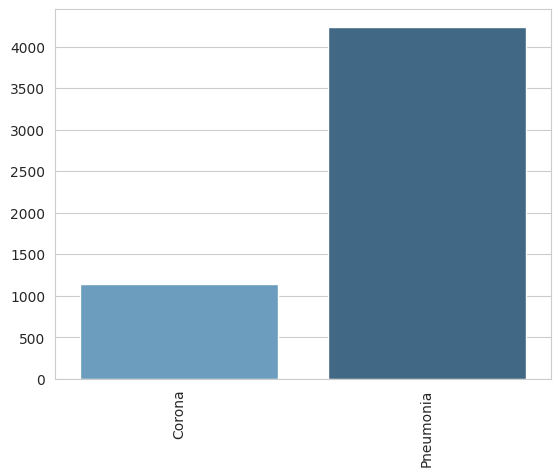

In [ ]:
image_count_1_COPN= len(list(base_1_COPN.glob('*/*.png')))
image_count_2_COPN = len(list(base_1_COPN.glob('*/*.jpeg')))
image_count_3_COPN = len(list(base_1_COPN.glob('*/*.jpg')))

image_count = image_count_1_COPN + image_count_2_COPN + image_count_3_COPN

print(f'Total images: {image_count}')
print(f'Total number of classes: {len(disease_classes_1_COPN)}  \n')
count = 0
disease_count_1_COPN = []
for x in disease_classes_1_COPN:
  print(f'Total {x} images: {len(diseases_1_COPN[count])} \n')
  disease_count_1_COPN.append(len(diseases_1_COPN[count]))
  count+=1

sns.set_style('whitegrid')
sns.barplot(x=disease_classes_1_COPN, y=disease_count_1_COPN, palette="Blues_d")
plt.xticks(rotation=90)
plt.show()


Image dimensions: (3480, 4248, 3)


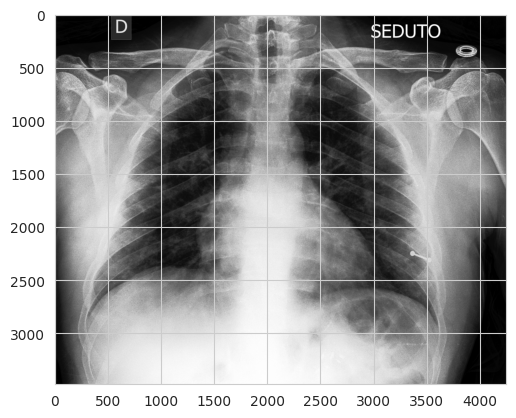

In [ ]:
sample_img = cv2.imread('/content/Dataset/Corona/Corona (1).jpeg')
plt.imshow(sample_img)

print(f'Image dimensions: {sample_img.shape}')

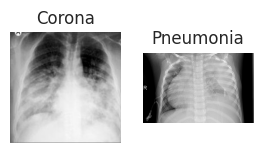

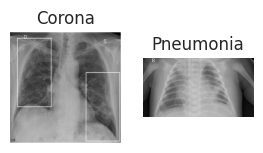

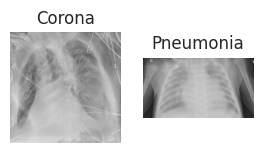

In [ ]:
def load_random_img(dir, label):
    plt.figure(figsize=(10,10))
    i=0
    for label in disease_classes_1_COPN:
        i+=1
        plt.subplot(1,6, i)
        file = random.choice(os.listdir(f'{dir}/{label}'))
        image_path = os.path.join(f'{dir}/{label}', file)
        img=cv2.imread(image_path)
        plt.title(label)
        plt.imshow(img)
        plt.grid(None)
        plt.axis('off')
for i in range(3):
       load_random_img(base_1_COPN,disease_classes_1_COPN)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 224                                                # We'll resize input X-ray images to this size
img_height, img_width = 512, 512
patch_size = 10                                                 # Size of the patches to be extract from the input Chest X-ray images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
 projection_dim * 2,
 projection_dim,
]                                                               # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
train_datagen_1_COPN = ImageDataGenerator(
 rescale = 1./255.,
 rotation_range=30,
 zoom_range=0.15,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.15,
 horizontal_flip=True,
 fill_mode="nearest",
 )


test_datagen_1_COPN = ImageDataGenerator(rescale = 1./255)
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_1_COPN = image_dataset_from_directory('disease_1_COPN/train',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 validation_split = 0.2,
 seed = 42,
 subset = 'training'
 )



Found 3227 files belonging to 2 classes.
Using 2582 files for training.


In [ ]:
test_data_1_COPN = image_dataset_from_directory('disease_1_COPN/test',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = False,
 )
valid_data_1_COPN = image_dataset_from_directory('disease_1_COPN/val',
 label_mode = 'categorical',
 batch_size = batch_size,
 image_size = (image_size,image_size),
 shuffle = True,
 seed = 42,
 validation_split = 0.2,
 subset = 'validation'
 )

Found 1077 files belonging to 2 classes.
Found 1075 files belonging to 2 classes.
Using 215 files for validation.


In [ ]:
data_augmentation_1_COPN = keras.Sequential(
 [
 layers.Normalization(),
 layers.Resizing(image_size, image_size),
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(factor=0.02),
 layers.RandomZoom(
 height_factor=0.2, width_factor=0.2
 ),
 ],
 name="data_augmentation_1_COPN",
)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        super(Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
classes_1_COPN = os.listdir('/content/disease_1_COPN/train')

train_length_1_Corona_COPN = len(os.listdir('/content/disease_1_COPN/train/Corona'))
train_length_1_Pneumonia_COPN = len(os.listdir('/content/disease_1_COPN/train/Pneumonia'))
# train_length_1_Tuberculosis_PNTB = len(os.listdir('/content/disease_1_PNTB/train/Tuberculosis'))

train_length_1_Corona_COPN,train_length_1_Pneumonia_COPN,classes_1_COPN

(685, 2542, ['Pneumonia', 'Corona'])

In [ ]:


val_length_1_Corona_COPN = len(os.listdir('/content/disease_1_COPN/val/Corona'))
val_length_1_Pneumonia_COPN = len(os.listdir('//content/disease_1_COPN/val/Pneumonia'))
# train_length_1_Tuberculosis_PNTB = len(os.listdir('/content/disease_1_PNTB/train/Tuberculosis'))

val_length_1_Corona_COPN,val_length_1_Pneumonia_COPN

(228, 847)

In [ ]:

test_length_1_Corona_COPN = len(os.listdir('/content/disease_1_COPN/test/Corona'))
test_length_1_Pneumonia_COPN = len(os.listdir('/content/disease_1_COPN/test/Pneumonia'))
# train_length_1_Tuberculosis_PNTB = len(os.listdir('/content/disease_1_PNTB/train/Tuberculosis'))

test_length_1_Corona_COPN,test_length_1_Pneumonia_COPN

(229, 848)

In [ ]:
class_names_1_COPN = train_data_1_COPN.class_names
class_names_1_COPN

['Corona', 'Pneumonia']

In [ ]:
train_dir_1_COPN = '/content/disease_1_COPN/train/'

Image size: 224 X 224
Patch size: 10 X 10
Patches per image: 484
Elements per patch: 300


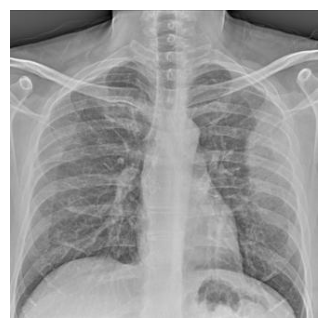

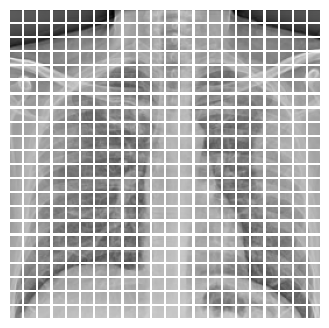

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(4, 4))
target = train_dir_1_COPN + "Corona"
random_num = random.choice(os.listdir(target))
image = mpimg.imread(train_dir_1_COPN + "Corona" + "/" + random_num)
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(
 tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):

    def __init__(self, num_patches, projection_dim):

        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
        )
    def call(self, patch):

        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():

    inputs = layers.Input(shape=(image_size,image_size,3))
# Augment data.
    augmented = data_augmentation_1_COPN(inputs,training = True)
# Create patches.
    patches = Patches(patch_size)(augmented)
# Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)



# Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
# Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
# Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
         num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
# Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
# Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
# MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
# Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
# Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.5)(representation)
# Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
# Classify outputs.
        logits = layers.Dense(len(class_names_1_COPN))(features)
# Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=logits)
        return model


In [ ]:
import datetime
import os

def create_tensorboard_callbacks(dir,model_no):
    log_dir1 = dir + model_no + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir1 = dir + model_no + datetime.datetime.now().strftime( )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir1=log_dir1, histogram_freq=1)
    return tensorboard_callback

#We will be using Sayak Paul pretrained vision transformer models.
feature_extractor_layer = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_r50_l32_fe/1",
                                 input_shape = (224,224,3),
                                 trainable = False,
                                 name = "Pre_trained")


model_1_COPN = tf.keras.Sequential([
                              feature_extractor_layer,
                              layers.Dense(2,activation='softmax')
],name = "model_1_COPN")
model_1_COPN.summary()


Model: "model_1_COPN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Pre_trained (KerasLayer)    (None, 1024)              327969856 
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 327,971,906
Trainable params: 2,050
Non-trainable params: 327,969,856
_________________________________________________________________


In [ ]:
random.seed(50)

model_1_COPN.compile(
 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
 optimizer = tfa.optimizers.AdamW(weight_decay = 0.0001,
                                  learning_rate = 0.001),
                                  metrics = ['accuracy'])
history_1_COPN = model_1_COPN.fit(
 train_data_1_COPN ,
 epochs=12,
 validation_data = valid_data_1_COPN
 )

Epoch 1/12


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


41/41 [==============================] - 189s 3s/step - loss: 0.2380 - accuracy: 0.9167 - val_loss: 0.1057 - val_accuracy: 0.9674
Epoch 2/12
41/41 [==============================] - 39s 896ms/step - loss: 0.0388 - accuracy: 0.9872 - val_loss: 0.0709 - val_accuracy: 0.9860
Epoch 3/12
41/41 [==============================] - 37s 871ms/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 0.0629 - val_accuracy: 0.9860
Epoch 4/12
41/41 [==============================] - 39s 915ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0579 - val_accuracy: 0.9860
Epoch 5/12
41/41 [==============================] - 37s 872ms/step - loss: 0.0121 - accuracy: 0.9965 - val_loss: 0.0594 - val_accuracy: 0.9814
Epoch 6/12
41/41 [==============================] - 38s 862ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0549 - val_accuracy: 0.9860
Epoch 7/12
41/41 [==============================] - 37s 864ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0537 - val_accuracy: 0.9860
Epoch 8/12
4

17/17 [==============================] - 49s 3s/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] tf.Tensor([0 0 0 0 0 0 0 0 0 0], shape=(10,), dtype=int64)


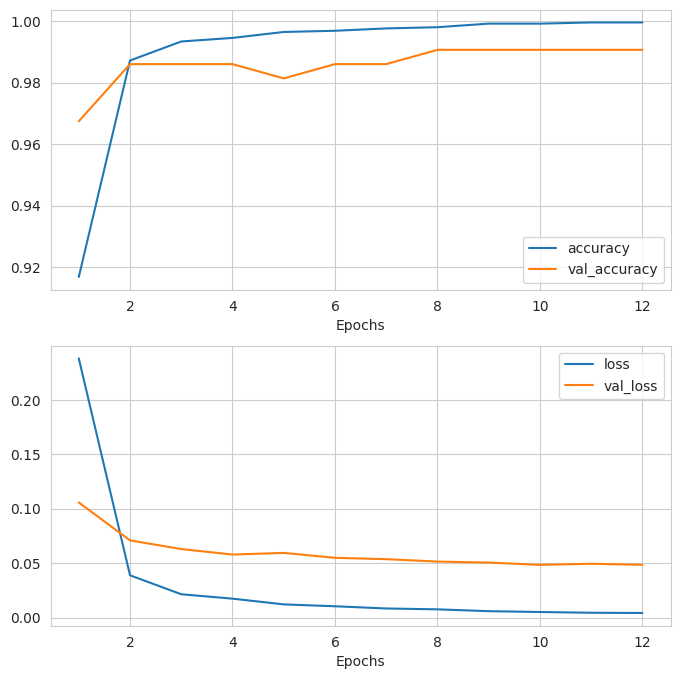

In [ ]:
import matplotlib.pyplot as plt
def plot_graph(history):

    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    epochs=range(1,len(history.history['loss'])+1)
    plt.plot(epochs,history.history['loss'],label='loss')
    plt.plot(epochs,history.history['val_loss'],label='val_loss')
    plt.xlabel('Epochs')
    # plt.title('Training vs Validation loss')
    plt.legend()
    plt.subplot(2,1,1)
    plt.plot(epochs,history.history['accuracy'],label='accuracy')
    plt.plot(epochs,history.history['val_accuracy'],label='val_accuracy')
    plt.xlabel('Epochs')
    # plt.title('Training vs Validation accuracy')
    plt.legend()

plot_graph(history_1_COPN)


y_labels = []

for image,label in test_data_1_COPN.unbatch():
     y_labels.append(label.numpy().argmax())

pred_prob = model_1_COPN.predict(test_data_1_COPN)

preds = tf.argmax(pred_prob,axis = 1 )

print(y_labels[:10],preds[:10])

In [ ]:
random.seed(50)
model_1_COPN.evaluate(test_data_1_COPN)

17/17 [==============================] - 13s 778ms/step - loss: 0.0050 - accuracy: 0.9991


[0.005043851211667061, 0.999071478843689]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       229
           1       1.00      1.00      1.00       848

    accuracy                           1.00      1077
   macro avg       1.00      1.00      1.00      1077
weighted avg       1.00      1.00      1.00      1077



In [ ]:
def load_and_prep_image(filename,image_shape=224,scale=True):

    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img,channels=3)
    img = tf.image.resize(img,size=[image_shape,image_shape])
    if scale:
        return img/255.
    else:
        return img

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
c = confusion_matrix(y_labels,preds)
c


array([[228,   1],
       [  0, 848]])

1/1 [==============================] - 0s 41ms/step


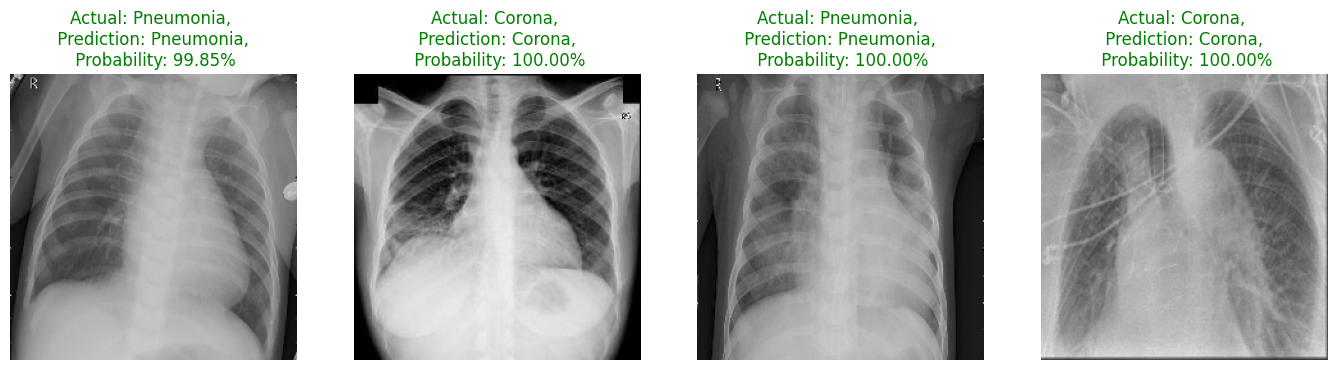

In [ ]:
random.seed(40)
import os
import random
plt.figure(figsize=(17,10))

for i in range(4):
    class_name=random.choice(test_data_1_COPN.class_names)
    filename=random.choice(os.listdir('disease_1_COPN/test'+'/'+class_name))
    filepath='disease_1_COPN/test'+"/"+class_name+'/'+filename
    img = load_and_prep_image(filepath,scale=True)
    pred_prob=model_1_COPN.predict(tf.expand_dims(img,axis=0))
    pred_class = test_data_1_COPN.class_names[pred_prob.argmax()]

    plt.subplot(1,4,i+1)
    plt.imshow(img)
    if class_name == pred_class:
        title_color='g'
    else:
        title_color='r'
    plt.title(f'Actual: {class_name}, \n Prediction: {pred_class}, \n Probability: {pred_prob.max()*100:.2f}%',c=title_color)
    plt.axis(False)

In [ ]:
model_1_COPN.save("Model_99")

NameError: ignored

In [ ]:
# import tensorflow as tf
# import numpy as np
# import cv2
# import os
# import random
# import matplotlib.pyplot as plt
# import tensorflow_addons as tfa

# # Define the load_and_prep_image function
# def load_and_prep_image(filepath, scale=True):
#     img = cv2.imread(filepath)
#     # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img.astype('float32') / 255.0
#     if scale:
#         img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
#     return img

# custom_objects = {'AdamW': tfa.optimizers.AdamW}

# # Load the saved model
# with tf.keras.utils.custom_object_scope(custom_objects):
#     model = tf.keras.models.load_model('/content/Model_99')

# # Load the saved model
# # model = tf.keras.models.load_model('/content/Model_99')




/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Enter path to the image file: /content/Dataset/Pneumonia/0107.jpeg
1/1 [==============================] - 0s 42ms/step


(-0.5, 223.5, 223.5, -0.5)

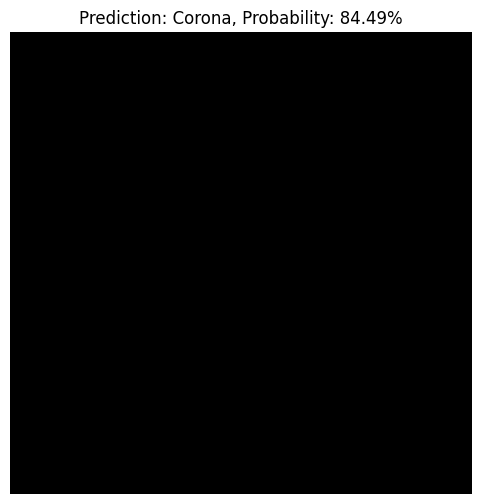

In [ ]:
# # Get user input for the image file path
# image_file_path = input('Enter path to the image file: ')

# # Load and prepare the image
# img = load_and_prep_image(image_file_path, scale=True)

# # Make prediction
# pred_prob = model.predict(tf.expand_dims(img, axis=0))
# pred_class = "Pneumonia" if pred_prob.argmax() == 1 else "Corona"

# # Display the image and prediction result
# plt.figure(figsize=(6,6))
# plt.imshow(img)
# plt.title(f'Prediction: {pred_class}, Probability: {pred_prob.max()*100:.2f}%')
# plt.axis(False)